> ### EEE6503-01: Computer Vision

# Final Project: Domain Generalization

**<div style="text-align: right"> Due date: June 17th, 2025. </div>** 
**<div style="text-align: right"> Please upload your file @ learnus by 11:00 PM. </div>** 

### *Assignment Instructions:*
1. Write a program implementing a particular algorithm to solve a given problem.
2. You can use both Korean and English for your report.
3. **Analyze the algorithm, theoretically and empirically.** 
4. **Report your results.**   

<h2><span style="color:blue">[Group 10: 최광일, 정성호]</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2025-06-11 07:47:12.217491


The objective of this assignment is to address the domain generalization problem in neural networks.

In [2]:
# You may change the values below.
team_id = '010' # your team id - should be a three-digit number
root_dir = '../../PACS' # directory to the dataset
lr = 0.0001 # learning rate
step_size = 10 # scheduler step size (if used)

# You must not change the values below.
num_epochs = 10 # number of epochs
image_size = 64 # input image size
batch_size = 32 # batch size for training
model_name = f'{team_id}_model.pth' # model name
TEST_MODE = False # test mode -- evaluation for TAs
ONE_MODEL_MODE = False

In [37]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import ConcatDataset, DataLoader, Dataset
from torchvision import models
from torchvision.transforms import transforms
from tqdm import tqdm

# FPJ-GC
import torch.nn.functional as F
from torchvision.utils import make_grid

# FACT
from torch.fft import rfft2, irfft2

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class PACSDataset(Dataset):
	def __init__(self, root_dir, domain, transform=None):
		"""
		Args:
			root_dir (string): Directory with all the images.
			domains (list): Containing domains of interest, with element choices: 
				['photo', 'art_painting', 'cartoon', 'sketch'].
			transform (callable, optional): Optional transform to be applied on a sample.
		"""        
		self.root_dir = root_dir
		self.domain = domain
		self.transform = transform

		self.classes = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
		self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

		self.images = []
		self.labels = []

		# Load images and labels
		domain_dir = os.path.join(self.root_dir, self.domain)
		for cls_name in self.classes:
			cls_dir = os.path.join(domain_dir, cls_name)
			image_files = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg', '.png'))]

			for img_name in image_files:
				self.images.append(os.path.join(cls_dir, img_name))
				self.labels.append(self.class_to_idx[cls_name])

	def __len__(self):
		return len(self.images)

	def __getitem__(self, idx):
		img_path = self.images[idx]
		image = Image.open(img_path).convert('RGB')
		label = self.labels[idx]

		if self.transform:
			image = self.transform(image)

		return image, label

In [5]:
# Define transforms
transform_train = transforms.Compose([
	transforms.Resize((image_size, image_size)),
	transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
	])

transform_test = transforms.Compose([
	transforms.Resize((image_size, image_size)),
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
	])

# Create datasets
dataset_train = ConcatDataset([
	PACSDataset(root_dir, 'cartoon', transform=transform_train),
	PACSDataset(root_dir, 'art_painting', transform=transform_train),
	PACSDataset(root_dir, 'sketch', transform=transform_train),
	])

dataset_test = PACSDataset(root_dir, 'photo', transform=transform_test)

loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [6]:
# Let's visualize some images from the training set

import matplotlib.pyplot as plt
import numpy as np

def visualize_example_images(root_dir, domain):
	assert domain in ['art_painting', 'sketch', 'cartoon']

	def denormalize(tensor):
		"""Denormalize the image tensor for visualization"""
		mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
		std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
		return tensor * std + mean
	
 	# Create dataset
	dataset = PACSDataset(root_dir=root_dir, domain=domain, transform=transform_train)

	# Create a figure with subplots for each class
	fig, axs = plt.subplots(1, 7, figsize=(15, 3))
	fig.suptitle('Sample Images from Each Category')

	# For each class
	for i, class_name in enumerate(dataset.classes):
		# Find first image of this class
		for idx in range(len(dataset)):
			if dataset.labels[idx] == i:
				image, _ = dataset[idx]
				
				# Denormalize the image
				image = denormalize(image)
				
				# Convert to numpy and transpose for plotting
				image = image.numpy().transpose(1, 2, 0)
				
				# Clip values to [0, 1] range
				image = np.clip(image, 0, 1)
				
				# Plot
				axs[i].imshow(image)
				axs[i].set_title(class_name)
				axs[i].axis('off')
				break

	plt.tight_layout()
	plt.show()

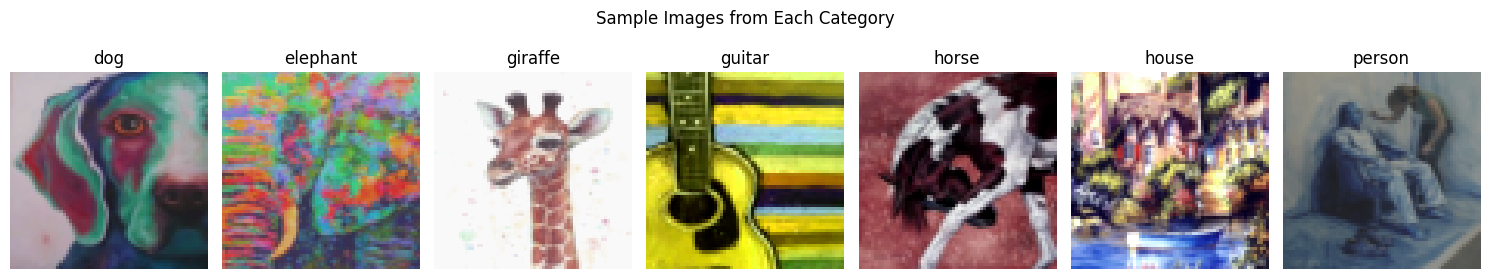

In [7]:
visualize_example_images(root_dir, 'art_painting')

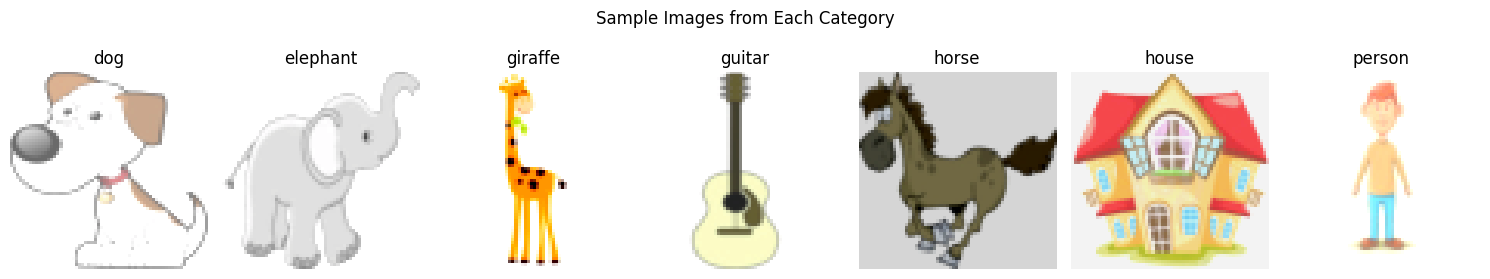

In [8]:
visualize_example_images(root_dir, 'cartoon')

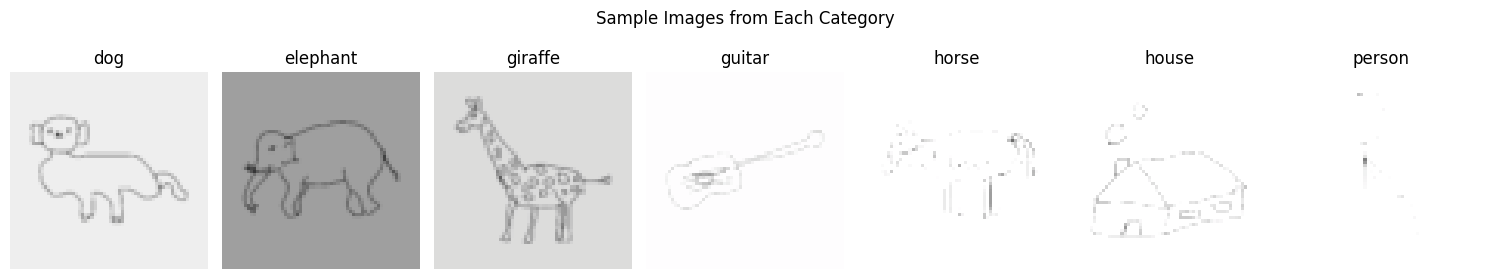

In [9]:
visualize_example_images(root_dir, 'sketch')

# Train : BASE

In [10]:
def train_base():
# Load ResNet50 model pre-trained on ImageNet
	model = models.resnet50(weights='ResNet50_Weights.DEFAULT')

	# Modify the last fully connected layer for 7 classes (PACS has 7 classes)
	num_features = model.fc.in_features
	model.fc = nn.Linear(num_features, 7)

	# Instantiate loss, optimizer, and scheduler
	criterion = nn.CrossEntropyLoss()
	optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
	scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)

	max_accuracy = 0.0
	train_losses, test_accuracies = [], []
	if not TEST_MODE:
		device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

		model = model.to(device)

		for epoch in range(num_epochs):
			model.train()
			running_loss = 0.0
			correct = 0
			total = 0

			for i, (inputs, labels) in enumerate(tqdm(loader_train, desc=f'Epoch {epoch+1}/{num_epochs}')):
				inputs, labels = inputs.to(device), labels.to(device)

				optimizer.zero_grad()

				outputs = model(inputs)

				loss = criterion(outputs, labels)
				loss.backward()
				optimizer.step()

				running_loss += loss.item()
				_, predicted = outputs.max(1)
				total += labels.size(0)
				correct += predicted.eq(labels).sum().item()

				# Store loss at every iteration
				train_losses.append(loss.item())
				
			scheduler.step()

			# Validation
			model.eval()
			correct = 0
			total = 0
			with torch.no_grad():
				for inputs, labels in loader_test:
					inputs, labels = inputs.to(device), labels.to(device)
					outputs = model(inputs)
					_, predicted = outputs.max(1)
					total += labels.size(0)
					correct += predicted.eq(labels).sum().item()

			test_accuracy = 100 * correct / total
			test_accuracies.append(test_accuracy)
			max_accuracy = max(max_accuracy, test_accuracy)
		
			current_lr = optimizer.param_groups[0]['lr']
			print(f'Epoch [{epoch+1}/{num_epochs}], '
						f'Loss: {running_loss/len(loader_train):.4f}, '
						f'Test Accuracy: {test_accuracy:.2f}%, '
						f'Learning Rate: {current_lr:.6f}')

		print('Finished Training')

		# Save the model - make sure you include this file in your submission
		torch.save(model.state_dict(), f'./{model_name}_base')

	if ONE_MODEL_MODE : 
		# Plotting after training is finished
		plt.figure(figsize=(6, 4))

		# Plot training loss
		plt.subplot(1, 2, 1)
		plt.plot(train_losses)
		plt.title('Training Loss')
		plt.xlabel('Iteration')
		plt.ylabel('Loss')

		# Plot test accuracy
		plt.subplot(1, 2, 2)
		plt.plot(test_accuracies)
		plt.title('Test Accuracy')
		plt.xlabel('Epoch')
		plt.ylabel('Accuracy (%)')

		plt.tight_layout()
		plt.show()
	return max_accuracy, train_losses, test_accuracies

In [11]:
if ONE_MODEL_MODE : 
    train_base()

# Train : MMD

In [12]:
# 수정된 ResNet50 with intermediate feature hook
class ResNetWithFeatures(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        base = models.resnet50(weights='ResNet50_Weights.DEFAULT')
        self.backbone = nn.Sequential(*list(base.children())[:-1])  # fc 제거
        self.fc = nn.Linear(base.fc.in_features, num_classes)

    def forward(self, x, return_features=False):
        features = self.backbone(x)
        features = features.view(features.size(0), -1)  # flatten
        logits = self.fc(features)
        if return_features:
            return logits, features
        return logits

# MMD 구현 함수
def gaussian_kernel(x, y, sigma_val):
    x = x.unsqueeze(1)          # (B,1,D)
    y = y.unsqueeze(0)          # (1,B,D)
    dist = ((x - y) ** 2).sum(2)
    return torch.exp(-dist / (2 * sigma_val ** 2 + 1e-8))

def compute_mmd(x1, x2, sigmas=(1, 2, 4, 8)):
    mmd2 = 0
    for s in sigmas:
        Kxx = gaussian_kernel(x1, x1, s)
        Kyy = gaussian_kernel(x2, x2, s)
        Kxy = gaussian_kernel(x1, x2, s)

        # unbiased: diag 제외
        def off_diag(mat):      # (N,N)
            return mat.sum() - mat.diagonal().sum()

        m = x1.size(0); n = x2.size(0)
        mmd2 += (off_diag(Kxx) / (m*(m-1))
                + off_diag(Kyy) / (n*(n-1))
                - 2 * Kxy.mean())
    return mmd2 / len(sigmas)

lambda_mmd = 0.1  # MMD 손실 가중치

In [13]:
class PACSDatasetWithDomain(PACSDataset):
    def __init__(self, root_dir, domain_name, domain_id, transform=None):
        super().__init__(root_dir, domain_name, transform=transform)
        self.domain_id = domain_id

    def __getitem__(self, idx):
        image, label = super().__getitem__(idx)
        return image, label, self.domain_id
# 도메인별 정수 ID 지정
domain_to_id = {'cartoon': 0, 'art_painting': 1, 'sketch': 2}

dataset_train_mmd = ConcatDataset([
    PACSDatasetWithDomain(root_dir, 'cartoon', domain_to_id['cartoon'], transform=transform_train),
    PACSDatasetWithDomain(root_dir, 'art_painting', domain_to_id['art_painting'], transform=transform_train),
    PACSDatasetWithDomain(root_dir, 'sketch', domain_to_id['sketch'], transform=transform_train),
])
dataset_test_mmd = PACSDataset(root_dir, 'photo', transform=transform_test)
loader_train_mmd = DataLoader(dataset_train_mmd, batch_size=batch_size, shuffle=True)

In [14]:
def train_mmd():
	model_mmd = ResNetWithFeatures(num_classes=7)

	# Instantiate loss, optimizer, and scheduler
	criterion_mmd = nn.CrossEntropyLoss()
	optimizer_mmd = optim.SGD(model_mmd.parameters(), lr=lr, momentum=0.9)
	scheduler_mmd = lr_scheduler.StepLR(optimizer_mmd, step_size=step_size, gamma=0.1)


	# Lists to store loss and accuracy values
	max_accuracy = 0.0
	train_losses, test_accuracies = [], []
	if not TEST_MODE:
		device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

		model_mmd = model_mmd.to(device)

		for epoch in range(num_epochs):
			model_mmd.train()
			running_loss = 0.0
			correct = 0
			total = 0

			cls_tot = 0.0
			cls_cnt = 0
			mmd_tot = 0.0
			mmd_cnt = 0

			for i, (inputs, labels, domains) in enumerate(tqdm(loader_train_mmd, desc=f'Epoch {epoch+1}/{num_epochs}')):
				inputs, labels, domains = inputs.to(device), labels.to(device), domains.to(device)

				optimizer_mmd.zero_grad()

				outputs, features = model_mmd(inputs, return_features=True)

				loss = criterion_mmd(outputs, labels)

				cls_tot += loss.item()
				cls_cnt += 1

				unique_domains = torch.unique(domains)
				mmd_loss = 0.0
				for di in range(len(unique_domains)):
					for dj in range(di + 1, len(unique_domains)):
						f1 = features[domains == unique_domains[di]]
						f2 = features[domains == unique_domains[dj]]
						if f1.size(0) > 1 and f2.size(0) > 1:
							pair_mmd = compute_mmd(f1, f2)
							mmd_loss += pair_mmd
							mmd_tot  += pair_mmd.item()
							mmd_cnt += 1

				if mmd_cnt > 0:
					mmd_loss = mmd_loss / mmd_cnt

				loss = loss + lambda_mmd * mmd_loss
				loss.backward()
				optimizer_mmd.step()

				running_loss += loss.item()
				_, predicted = outputs.max(1)
				total += labels.size(0)
				correct += predicted.eq(labels).sum().item()

				# Store loss at every iteration
				train_losses.append(loss.item())
				
			scheduler_mmd.step()

			# Validation
			model_mmd.eval()
			correct = 0
			total = 0
			with torch.no_grad():
				for inputs, labels in loader_test:
					inputs, labels = inputs.to(device), labels.to(device)
					outputs, features = model_mmd(inputs, return_features=True)
					_, predicted = outputs.max(1)
					total += labels.size(0)
					correct += predicted.eq(labels).sum().item()

			test_accuracy = 100 * correct / total
			test_accuracies.append(test_accuracy)
			max_accuracy = max(max_accuracy, test_accuracy)
		
			current_lr = optimizer_mmd.param_groups[0]['lr']
			print(f'Epoch [{epoch+1}/{num_epochs}], '
						f'Loss: {running_loss/len(loader_train):.4f}, '
						f'Test Accuracy: {test_accuracy:.2f}%, '
						f'Learning Rate: {current_lr:.6f}, '
						f'Average MMD: {mmd_tot / (mmd_cnt + 1e-5):.4f}, '
						f'Average CLS: {cls_tot / (cls_cnt + 1e-5):.4f}')

		print('Finished Training')

		# Save the model - make sure you include this file in your submission
		torch.save(model_mmd.state_dict(), f'./{model_name}_mmd')

	if ONE_MODEL_MODE : 
		# Plotting after training is finished
		plt.figure(figsize=(6, 4))

		# Plot training loss
		plt.subplot(1, 2, 1)
		plt.plot(train_losses)
		plt.title('Training Loss')
		plt.xlabel('Iteration')
		plt.ylabel('Loss')

		# Plot test accuracy
		plt.subplot(1, 2, 2)
		plt.plot(test_accuracies)
		plt.title('Test Accuracy')
		plt.xlabel('Epoch')
		plt.ylabel('Accuracy (%)')

		plt.tight_layout()
		plt.show()
	return max_accuracy, train_losses, test_accuracies

In [15]:
if ONE_MODEL_MODE : 
    train_mmd()

# Train : FACT

In [16]:
def amplitude_mix(images, eta=0.5):
    """
    images : (B, C, H, W)  float tensor
    returns: 동일 shape (B, C, H, W)
    """
    B, C, H, W = images.shape
    perm = torch.randperm(B, device=images.device)
    imgs2 = images[perm]

    # FFT
    fft1 = torch.fft.rfft2(images, norm='ortho')
    fft2 = torch.fft.rfft2(imgs2,  norm='ortho')

    amp1, phase1 = torch.abs(fft1), torch.angle(fft1)
    amp2 = torch.abs(fft2)

    # -------- FIXED: 4-D λ --------
    lam = eta * torch.rand(B, 1, 1, 1, device=images.device)
    amp_mix = lam * amp1 + (1 - lam) * amp2
    # ------------------------------

    fft_mix = amp_mix * torch.exp(1j * phase1)
    aug = torch.fft.irfft2(fft_mix, s=(H, W), norm='ortho')

    # 값 범위/자료형 보정
    return aug.clamp_(images.min(), images.max()).type_as(images)

eta   = 0.3     # Amplitude 혼합 세기
beta  = 0.25     # Consistency 손실 가중치
temp  = 3.0     # Temperature scaling

In [17]:
def train_fact():
    # Load ResNet50 model pre-trained on ImageNet
    model_fact = models.resnet50(weights='ResNet50_Weights.DEFAULT')

    # Modify the last fully connected layer for 7 classes (PACS has 7 classes)
    num_features = model_fact.fc.in_features
    model_fact.fc = nn.Linear(num_features, 7)

    # Instantiate loss, optimizer, and scheduler
    criterion_fact = nn.CrossEntropyLoss()
    optimizer_fact = optim.SGD(model_fact.parameters(), lr=lr, momentum=0.9)
    scheduler_fact = lr_scheduler.StepLR(optimizer_fact, step_size=step_size, gamma=0.1)

    max_accuracy = 0.0
    train_losses, test_accuracies = [], []

    if not TEST_MODE:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        model_fact = model_fact.to(device)

        for epoch in range(num_epochs):
            model_fact.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for i, (inputs, labels) in enumerate(tqdm(loader_train, desc=f'Epoch {epoch+1}/{num_epochs}')):
                inputs, labels = inputs.to(device), labels.to(device)

                # ① FACT 증강
                inputs_aug = amplitude_mix(inputs, eta=eta)

                # ② Forward
                outputs_ori = model_fact(inputs)        # 원본
                outputs_aug = model_fact(inputs_aug)    # 증강본

                # ③ 손실 계산
                loss_cls_ori = criterion_fact(outputs_ori, labels)
                loss_cls_aug = criterion_fact(outputs_aug, labels)

                p_ori = F.log_softmax(outputs_ori / temp, dim=1)
                q_aug = F.softmax(outputs_aug / temp, dim=1)
                p_aug = F.log_softmax(outputs_aug / temp, dim=1)
                q_ori = F.softmax(outputs_ori / temp, dim=1)
                loss_cons = (F.kl_div(p_ori, q_aug, reduction='batchmean') +
                            F.kl_div(p_aug, q_ori, reduction='batchmean')) * (temp ** 2) / 2

                loss = loss_cls_ori + loss_cls_aug + beta * loss_cons

                # ④ Back-prop
                optimizer_fact.zero_grad()

                loss.backward()
                optimizer_fact.step()

                running_loss += loss.item()
                _, predicted = outputs_ori.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                # Store loss at every iteration
                train_losses.append(loss.item())

            scheduler_fact.step()

            # Validation
            model_fact.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in loader_test:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model_fact(inputs)
                    _, predicted = outputs.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()

            test_accuracy = 100 * correct / total
            test_accuracies.append(test_accuracy)
            max_accuracy = max(max_accuracy, test_accuracy)
            
            current_lr = optimizer_fact.param_groups[0]['lr']
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                        f'Loss: {running_loss/len(loader_train):.4f}, '
                        f'Test Accuracy: {test_accuracy:.2f}%, '
                        f'Learning Rate: {current_lr:.6f}')

        print('Finished Training')

        # Save the model - make sure you include this file in your submission
        torch.save(model_fact.state_dict(), f'./{model_name}_fact')
    
    if ONE_MODEL_MODE : 
        # Plotting after training is finished
        plt.figure(figsize=(6, 4))

        # Plot training loss
        plt.subplot(1, 2, 1)
        plt.plot(train_losses)
        plt.title('Training Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')

        # Plot test accuracy
        plt.subplot(1, 2, 2)
        plt.plot(test_accuracies)
        plt.title('Test Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')

        plt.tight_layout()
        plt.show()
    return max_accuracy, train_losses, test_accuracies

In [18]:
if ONE_MODEL_MODE : 
    train_fact()

# Train : FPJ-GC (Fourier-Phase Jitter with Graph Consistency)

In [19]:
def phase_jitter(x, r_split=0.25, sigma_l=0.05, sigma_h=0.1):
    B, C, H, W = x.shape                     # 64×64 입력 전제
    fft   = torch.fft.rfft2(x, norm='ortho')
    amp, ph = torch.abs(fft), torch.angle(fft)

    fy = torch.fft.fftfreq (H, d=1./H).to(x.device)   # 길이 64  ← 수정
    fx = torch.fft.rfftfreq(W, d=1./W).to(x.device)   # 길이 33
    R  = torch.sqrt(fy[:, None]**2 + fx[None, :]**2)  # (64, 33)

    mask_low  = (R <= r_split)
    mask_high = ~mask_low

    eps_l = sigma_l * torch.randn_like(ph)
    eps_h = sigma_h * torch.randn_like(ph)

    ph_j  = ph + eps_l * mask_low + (-eps_h) * mask_high
    jitter = torch.fft.irfft2(amp * torch.exp(1j * ph_j),
                            s=(H, W), norm='ortho')
    return jitter.type_as(x)

lambda_graph = 0.2   # 그래프 일관성 가중치  (FPJ-GC)

In [ ]:
def train_fpjgc():
    model_fpjgc = models.resnet50(weights='ResNet50_Weights.DEFAULT')
    num_features = model_fpjgc.fc.in_features
    model_fpjgc.fc = nn.Linear(num_features, 7)

    feature_extractor = nn.Sequential(*list(model_fpjgc.children())[:-1])  # AvgPool 포함
    criterion_fpjgc  = nn.CrossEntropyLoss()
    optimizer_fpjgc  = optim.SGD(model_fpjgc.parameters(), lr=lr, momentum=0.9)
    scheduler_fpjgc  = lr_scheduler.StepLR(optimizer_fpjgc, step_size=step_size, gamma=0.1)

    max_accuracy = 0.0
    train_losses, test_accuracies = [], []

    if not TEST_MODE:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model_fpjgc, feature_extractor = model_fpjgc.to(device), feature_extractor.to(device)

        _mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
        _std  = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)
        show_example = True

        for epoch in range(num_epochs):
            model_fpjgc.train()
            running_loss, correct, total = 0.0, 0, 0

            for inputs, labels in tqdm(loader_train, desc=f'Epoch {epoch+1}/{num_epochs}'):
                inputs, labels = inputs.to(device), labels.to(device)

                # ---------- FPJ-GC: jitter view ----------
                progress = epoch / num_epochs
                lambda_g  = 0.0 if progress < 0.1 else 0.2 * (1 - progress*0.6)  # 0→0.2→0.08
                sigma_l   = 0.05 * (1 - 0.5*progress)                            # 0.05→0.0125
                sigma_h   = 0.10 * (1 - 0.5*progress)                            # 0.10→0.025
                inputs_jit = phase_jitter(inputs, sigma_l=sigma_l, sigma_h=sigma_h)

                if show_example:
                    with torch.no_grad():
                        # --- un-normalize ---
                        orig = (inputs[:4]      * _std + _mean).clamp(0, 1)
                        jitt = (inputs_jit[:4]  * _std + _mean).clamp(0, 1)
                        diff = (jitt - orig).abs() * 10.0        # 차이 강조 배율
                        diff = diff.clamp(0, 1)                  # 시각화용 [0,1]

                        # (1) Original (2) Jitter (3) |Δ|×5 → 세로 concat
                        sample = torch.cat([orig, jitt, diff])   # 총 12장
                        grid   = make_grid(sample, nrow=4)       # nrow=4 → 3행

                        plt.figure(figsize=(8,6))
                        plt.imshow(grid.permute(1, 2, 0).cpu())
                        plt.title("Row1: Original | Row2: Jitter | Row3: |diff|×10")
                        plt.axis('off')
                        plt.show()
                    show_example = False

                optimizer_fpjgc.zero_grad()

                # forward 두 번
                outputs_ori = model_fpjgc(inputs)
                outputs_jit = model_fpjgc(inputs_jit)

                loss_cls = criterion_fpjgc(outputs_ori, labels) + criterion_fpjgc(outputs_jit, labels)

                # ----- 그래프 일관성 -----
                with torch.no_grad():
                    feat_ori = feature_extractor(inputs ).view(inputs.size(0), -1)
                    feat_jit = feature_extractor(inputs_jit).view(inputs.size(0), -1)
                z  = F.normalize(feat_ori, dim=1)
                zt = F.normalize(feat_jit, dim=1)
                S  = z  @ z .T            # (B,B)
                St = zt @ zt.T
                loss_graph = F.mse_loss(S, St)

                loss = loss_cls + lambda_graph * loss_graph
                # ------------------------

                loss.backward()
                optimizer_fpjgc.step()

                running_loss += loss.item()
                _, pred = outputs_ori.max(1)
                total += labels.size(0)
                correct += pred.eq(labels).sum().item()
                train_losses.append(loss.item())

            scheduler_fpjgc.step()

            # ---------------- Validation (그대로) ----------------
            model_fpjgc.eval(); correct_val=total_val=0
            with torch.no_grad():
                for inputs, labels in loader_test:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model_fpjgc(inputs)
                    _, predicted = outputs.max(1)
                    total_val += labels.size(0)
                    correct_val += predicted.eq(labels).sum().item()
            test_accuracy = 100 * correct / total
            test_accuracies.append(test_accuracy)
            max_accuracy = max(max_accuracy, test_accuracy)

            current_lr = optimizer_fpjgc.param_groups[0]["lr"]
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                f'Loss: {running_loss/len(loader_train):.4f}, '
                f'Test Accuracy: {test_accuracy:.2f}%, '
                f'Learning Rate: {current_lr:.6f}')

        print('Finished Training')

        # Save the model - make sure you include this file in your submission
        torch.save(model_fpjgc.state_dict(), f'./{model_name}_fpjgc')

    if ONE_MODEL_MODE : 
        # Plotting after training is finished
        plt.figure(figsize=(6, 4))

        # Plot training loss
        plt.subplot(1, 2, 1)
        plt.plot(train_losses)
        plt.title('Training Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')

        # Plot test accuracy
        plt.subplot(1, 2, 2)
        plt.plot(test_accuracies)
        plt.title('Test Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')

        plt.tight_layout()
        plt.show()
    return max_accuracy, train_losses, test_accuracies

In [21]:
if ONE_MODEL_MODE : 
    train_fpjgc()

# Train : LaPaR(Latent-Patch Re-Masking)

In [30]:
def remask_patch(F, k_frac=0.3):
    """
    F : (B,C,h,w)  layer3 feature map
    서로 다른 샘플 간 patch 일부를 무작위 교환.
    도메인 정보가 없다 하더라도 확률적으로 대부분 다른 도메인.
    """
    B, C, h, w = F.shape
    num = int(k_frac * h * w)                # 교환할 cell 수
    idx = torch.randperm(h * w, device=F.device)[:num]
    i, j = idx // w, idx % w                 # (num,) 좌표

    perm = torch.randperm(B, device=F.device)
    # 동일 인덱스가 나오면 한 칸 rotate
    same = perm == torch.arange(B, device=F.device)
    perm[same] = (perm[same] + 1) % B

    F_aug = F.clone()
    for b in range(B):
        F_aug[b, :, i, j] = F[perm[b], :, i, j]
    return F_aug

In [31]:
class LaPaRResNet(nn.Module):
    def __init__(self, num_classes=7, k_frac=0.3):
        super().__init__()
        self.k_frac = k_frac
        base = models.resnet50(weights='ResNet50_Weights.DEFAULT')
        self.conv1  = base.conv1;  self.bn1 = base.bn1; self.relu = base.relu
        self.maxpool= base.maxpool
        self.layer1 = base.layer1; self.layer2 = base.layer2; self.layer3 = base.layer3
        self.layer4 = base.layer4; self.avgpool = base.avgpool
        self.fc     = nn.Linear(base.fc.in_features, num_classes)

    def _forward_feature(self, x):
        x = self.conv1(x); x = self.bn1(x); x = self.relu(x); x = self.maxpool(x)
        x = self.layer1(x); x = self.layer2(x)
        f = self.layer3(x)                               # layer3 feature
        return f

    def forward(self, x, aug=False):
        """
        aug=False : 원본 forward
        aug=True  : LaPaR 패치 교환 후 forward
        """
        f = self._forward_feature(x)
        if aug:                                          # <-- 패치 교환
            f = remask_patch(f, self.k_frac)
        x = self.layer4(f)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

In [32]:
def train_lapar():
    model = LaPaRResNet(num_classes=7, k_frac=0.3)       # <- 변경
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)

    max_acc, train_losses, test_accuracies = 0.0, [], []

    if not TEST_MODE:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)

        for epoch in range(num_epochs):
            model.train()
            run_loss, total, correct = 0.0, 0, 0

            for X, y in tqdm(loader_train, desc=f'Epoch {epoch+1}/{num_epochs}'):
                X, y = X.to(device), y.to(device)
                optimizer.zero_grad()

                # -------- 두 뷰 forward --------
                out_ori = model(X, aug=False)
                out_aug = model(X, aug=True)
                loss = criterion(out_ori, y) + criterion(out_aug, y)
                # ------------------------------

                loss.backward()
                optimizer.step()

                run_loss += loss.item()
                _, pred = out_ori.max(1)
                total  += y.size(0)
                correct += pred.eq(y).sum().item()
                train_losses.append(loss.item())

            scheduler.step()

            # -------- Validation --------
            model.eval(); corr = tot = 0
            with torch.no_grad():
                for X, y in loader_test:
                    X, y = X.to(device), y.to(device)
                    out = model(X, aug=False)
                    _, pr = out.max(1)
                    tot  += y.size(0)
                    corr += pr.eq(y).sum().item()
            acc = 100 * corr / tot
            test_accuracies.append(acc)
            max_acc = max(max_acc, acc)

            print(f'Epoch {epoch+1}/{num_epochs} | '
                  f'Loss {run_loss/len(loader_train):.4f} | '
                  f'TestAcc {acc:.2f}%')

        print('Finished Training')
        torch.save(model.state_dict(), f'./{model_name}_lapar')

    if ONE_MODEL_MODE : 
        # Plotting after training is finished
        plt.figure(figsize=(6, 4))

        # Plot training loss
        plt.subplot(1, 2, 1)
        plt.plot(train_losses)
        plt.title('Training Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')

        # Plot test accuracy
        plt.subplot(1, 2, 2)
        plt.plot(test_accuracies)
        plt.title('Test Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')

        plt.tight_layout()
        plt.show()
    return max_acc, train_losses, test_accuracies

# Training Models

In [38]:
def evaluate_curated_pacs(model):
    # Custom Dataset
    class CustomDataset(Dataset):
        def __init__(self, root_dir, transform=None):
            self.root_dir = root_dir
            self.transform = transform
            self.images = []
            self.labels = []
            self.class_to_idx = {'dog': 0, 'elephant': 1, 'giraffe': 2, 'guitar': 3, 'horse': 4, 'house': 5, 'person': 6}
            self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
            
            for cls_name in self.class_to_idx.keys():
                cls_dir = os.path.join(self.root_dir, cls_name)
                for img_name in os.listdir(cls_dir):
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.images.append(os.path.join(cls_dir, img_name))
                        self.labels.append(self.class_to_idx[cls_name])

        def __len__(self):
            return len(self.images)

        def __getitem__(self, idx):
            img_path = self.images[idx]
            label = self.labels[idx]
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label

    # Load test data
    root_dir_test = './CuratedPACS'
    dataset_test = CustomDataset(root_dir_test, transform=transform_test)
    loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

    # Evaluation
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader_test:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            # 라벨 문자열 출력
            for t, p in zip(labels.cpu(), predicted.cpu()):
                true_name = dataset_test.idx_to_class[t.item()]
                pred_name = dataset_test.idx_to_class[p.item()]
                print(f"GT: {true_name:8s} | Pred: {pred_name:8s} {'✅' if t==p else '❌'}")

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    print(f"\nTest Accuracy: {100 * correct / total:.2f}%")
    return (correct / total)

Running: train_base()


Epoch 1/10: 100%|██████████| 261/261 [00:37<00:00,  6.99it/s]


Epoch [1/10], Loss: 1.8366, Test Accuracy: 35.27%, Learning Rate: 0.000100


Epoch 2/10: 100%|██████████| 261/261 [00:37<00:00,  6.99it/s]


Epoch [2/10], Loss: 1.5652, Test Accuracy: 53.29%, Learning Rate: 0.000100


Epoch 3/10: 100%|██████████| 261/261 [00:37<00:00,  6.99it/s]


Epoch [3/10], Loss: 1.3470, Test Accuracy: 60.90%, Learning Rate: 0.000100


Epoch 4/10: 100%|██████████| 261/261 [00:37<00:00,  6.99it/s]


Epoch [4/10], Loss: 1.1842, Test Accuracy: 60.60%, Learning Rate: 0.000100


Epoch 5/10: 100%|██████████| 261/261 [00:37<00:00,  6.99it/s]


Epoch [5/10], Loss: 1.0631, Test Accuracy: 63.65%, Learning Rate: 0.000100


Epoch 6/10: 100%|██████████| 261/261 [00:37<00:00,  7.00it/s]


Epoch [6/10], Loss: 0.9867, Test Accuracy: 63.77%, Learning Rate: 0.000100


Epoch 7/10: 100%|██████████| 261/261 [00:37<00:00,  6.99it/s]


Epoch [7/10], Loss: 0.9220, Test Accuracy: 66.11%, Learning Rate: 0.000100


Epoch 8/10: 100%|██████████| 261/261 [00:37<00:00,  7.00it/s]


Epoch [8/10], Loss: 0.8804, Test Accuracy: 64.31%, Learning Rate: 0.000100


Epoch 9/10: 100%|██████████| 261/261 [00:37<00:00,  7.00it/s]


Epoch [9/10], Loss: 0.8327, Test Accuracy: 66.29%, Learning Rate: 0.000100


Epoch 10/10: 100%|██████████| 261/261 [00:37<00:00,  7.00it/s]


Epoch [10/10], Loss: 0.7808, Test Accuracy: 67.96%, Learning Rate: 0.000010
Finished Training


/tmp/ipykernel_34001/3935985537.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)   # ✅ weights_only 제거


GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: elephant ❌
GT: dog      | Pred: horse    ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: horse    ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: person   ❌
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: horse    ❌
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog 

Epoch 1/10: 100%|██████████| 261/261 [00:37<00:00,  6.99it/s]


Epoch [1/10], Loss: 1.8448, Test Accuracy: 42.63%, Learning Rate: 0.000100


Epoch 2/10: 100%|██████████| 261/261 [00:37<00:00,  6.99it/s]


Epoch [2/10], Loss: 1.5473, Test Accuracy: 57.13%, Learning Rate: 0.000100


Epoch 3/10: 100%|██████████| 261/261 [00:37<00:00,  6.99it/s]


Epoch [3/10], Loss: 1.3229, Test Accuracy: 60.72%, Learning Rate: 0.000100


Epoch 4/10: 100%|██████████| 261/261 [00:37<00:00,  6.99it/s]


Epoch [4/10], Loss: 1.1695, Test Accuracy: 64.07%, Learning Rate: 0.000100


Epoch 5/10: 100%|██████████| 261/261 [00:37<00:00,  6.99it/s]


Epoch [5/10], Loss: 1.0661, Test Accuracy: 62.46%, Learning Rate: 0.000100


Epoch 6/10: 100%|██████████| 261/261 [00:37<00:00,  6.99it/s]


Epoch [6/10], Loss: 0.9840, Test Accuracy: 66.23%, Learning Rate: 0.000100


Epoch 7/10: 100%|██████████| 261/261 [00:37<00:00,  6.99it/s]


Epoch [7/10], Loss: 0.9146, Test Accuracy: 65.81%, Learning Rate: 0.000100


Epoch 8/10: 100%|██████████| 261/261 [00:37<00:00,  7.01it/s]


Epoch [8/10], Loss: 0.8569, Test Accuracy: 67.54%, Learning Rate: 0.000100


Epoch 9/10: 100%|██████████| 261/261 [00:37<00:00,  7.00it/s]


Epoch [9/10], Loss: 0.8005, Test Accuracy: 71.26%, Learning Rate: 0.000100


Epoch 10/10: 100%|██████████| 261/261 [00:37<00:00,  7.02it/s]


Epoch [10/10], Loss: 0.7521, Test Accuracy: 70.60%, Learning Rate: 0.000010
Finished Training
GT: dog      | Pred: horse    ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: person   ❌
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog   

Epoch 1/10: 100%|██████████| 261/261 [00:37<00:00,  6.95it/s]


Epoch [1/10], Loss: 1.8304, Test Accuracy: 28.02%, Learning Rate: 0.000100


Epoch 2/10: 100%|██████████| 261/261 [00:37<00:00,  6.99it/s]


Epoch [2/10], Loss: 1.5638, Test Accuracy: 54.07%, Learning Rate: 0.000100


Epoch 3/10: 100%|██████████| 261/261 [00:37<00:00,  7.00it/s]


Epoch [3/10], Loss: 1.3479, Test Accuracy: 60.60%, Learning Rate: 0.000100


Epoch 4/10: 100%|██████████| 261/261 [00:37<00:00,  7.01it/s]


Epoch [4/10], Loss: 1.1915, Test Accuracy: 66.35%, Learning Rate: 0.000100


Epoch 5/10: 100%|██████████| 261/261 [00:37<00:00,  7.00it/s]


Epoch [5/10], Loss: 1.0789, Test Accuracy: 68.14%, Learning Rate: 0.000100


Epoch 6/10: 100%|██████████| 261/261 [00:37<00:00,  7.01it/s]


Epoch [6/10], Loss: 0.9872, Test Accuracy: 69.58%, Learning Rate: 0.000100


Epoch 7/10: 100%|██████████| 261/261 [00:37<00:00,  7.01it/s]


Epoch [7/10], Loss: 0.9286, Test Accuracy: 71.68%, Learning Rate: 0.000100


Epoch 8/10: 100%|██████████| 261/261 [00:37<00:00,  7.00it/s]


Epoch [8/10], Loss: 0.8657, Test Accuracy: 69.34%, Learning Rate: 0.000100


Epoch 9/10: 100%|██████████| 261/261 [00:37<00:00,  6.99it/s]


Epoch [9/10], Loss: 0.8063, Test Accuracy: 72.87%, Learning Rate: 0.000100


Epoch 10/10: 100%|██████████| 261/261 [00:37<00:00,  6.99it/s]


Epoch [10/10], Loss: 0.7817, Test Accuracy: 74.07%, Learning Rate: 0.000010
Finished Training
GT: dog      | Pred: horse    ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: elephant ❌
GT: dog      | Pred: giraffe  ❌
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog   

Epoch 1/10: 100%|██████████| 261/261 [00:44<00:00,  5.92it/s]


Epoch [1/10], Loss: 1.8498, Test Accuracy: 32.28%, Learning Rate: 0.000100, Average MMD: 0.0024, Average CLS: 1.8498


Epoch 2/10: 100%|██████████| 261/261 [00:43<00:00,  5.93it/s]


Epoch [2/10], Loss: 1.5872, Test Accuracy: 49.40%, Learning Rate: 0.000100, Average MMD: 0.0008, Average CLS: 1.5872


Epoch 3/10: 100%|██████████| 261/261 [00:43<00:00,  5.94it/s]


Epoch [3/10], Loss: 1.3802, Test Accuracy: 57.25%, Learning Rate: 0.000100, Average MMD: 0.0003, Average CLS: 1.3802


Epoch 4/10: 100%|██████████| 261/261 [00:43<00:00,  5.95it/s]


Epoch [4/10], Loss: 1.2121, Test Accuracy: 62.81%, Learning Rate: 0.000100, Average MMD: 0.0001, Average CLS: 1.2121


Epoch 5/10: 100%|██████████| 261/261 [00:43<00:00,  5.93it/s]


Epoch [5/10], Loss: 1.0931, Test Accuracy: 65.99%, Learning Rate: 0.000100, Average MMD: 0.0001, Average CLS: 1.0931


Epoch 6/10: 100%|██████████| 261/261 [00:43<00:00,  5.95it/s]


Epoch [6/10], Loss: 1.0109, Test Accuracy: 63.65%, Learning Rate: 0.000100, Average MMD: 0.0001, Average CLS: 1.0109


Epoch 7/10: 100%|██████████| 261/261 [00:43<00:00,  5.95it/s]


Epoch [7/10], Loss: 0.9364, Test Accuracy: 68.92%, Learning Rate: 0.000100, Average MMD: 0.0001, Average CLS: 0.9364


Epoch 8/10: 100%|██████████| 261/261 [00:44<00:00,  5.92it/s]


Epoch [8/10], Loss: 0.8875, Test Accuracy: 70.00%, Learning Rate: 0.000100, Average MMD: 0.0001, Average CLS: 0.8875


Epoch 9/10: 100%|██████████| 261/261 [00:43<00:00,  5.94it/s]


Epoch [9/10], Loss: 0.8443, Test Accuracy: 70.42%, Learning Rate: 0.000100, Average MMD: 0.0000, Average CLS: 0.8443


Epoch 10/10: 100%|██████████| 261/261 [00:44<00:00,  5.92it/s]


Epoch [10/10], Loss: 0.7875, Test Accuracy: 73.71%, Learning Rate: 0.000010, Average MMD: 0.0000, Average CLS: 0.7875
Finished Training
GT: dog      | Pred: horse    ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: horse    ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: elephant ❌
GT: dog      | Pred: giraffe  ❌
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅


Epoch 1/10: 100%|██████████| 261/261 [00:44<00:00,  5.89it/s]


Epoch [1/10], Loss: 1.8526, Test Accuracy: 31.50%, Learning Rate: 0.000100, Average MMD: 0.0022, Average CLS: 1.8526


Epoch 2/10: 100%|██████████| 261/261 [00:44<00:00,  5.91it/s]


Epoch [2/10], Loss: 1.5719, Test Accuracy: 51.14%, Learning Rate: 0.000100, Average MMD: 0.0006, Average CLS: 1.5719


Epoch 3/10: 100%|██████████| 261/261 [00:43<00:00,  5.94it/s]


Epoch [3/10], Loss: 1.3458, Test Accuracy: 61.26%, Learning Rate: 0.000100, Average MMD: 0.0002, Average CLS: 1.3458


Epoch 4/10: 100%|██████████| 261/261 [00:44<00:00,  5.92it/s]


Epoch [4/10], Loss: 1.1843, Test Accuracy: 58.98%, Learning Rate: 0.000100, Average MMD: 0.0001, Average CLS: 1.1843


Epoch 5/10: 100%|██████████| 261/261 [00:43<00:00,  5.94it/s]


Epoch [5/10], Loss: 1.0765, Test Accuracy: 63.23%, Learning Rate: 0.000100, Average MMD: 0.0001, Average CLS: 1.0765


Epoch 6/10: 100%|██████████| 261/261 [00:43<00:00,  5.94it/s]


Epoch [6/10], Loss: 1.0004, Test Accuracy: 68.80%, Learning Rate: 0.000100, Average MMD: 0.0001, Average CLS: 1.0004


Epoch 7/10: 100%|██████████| 261/261 [00:44<00:00,  5.91it/s]


Epoch [7/10], Loss: 0.9160, Test Accuracy: 67.60%, Learning Rate: 0.000100, Average MMD: 0.0001, Average CLS: 0.9160


Epoch 8/10: 100%|██████████| 261/261 [00:43<00:00,  5.95it/s]


Epoch [8/10], Loss: 0.8569, Test Accuracy: 69.16%, Learning Rate: 0.000100, Average MMD: 0.0001, Average CLS: 0.8569


Epoch 9/10: 100%|██████████| 261/261 [00:43<00:00,  5.94it/s]


Epoch [9/10], Loss: 0.8006, Test Accuracy: 67.96%, Learning Rate: 0.000100, Average MMD: 0.0000, Average CLS: 0.8006


Epoch 10/10: 100%|██████████| 261/261 [00:43<00:00,  5.94it/s]


Epoch [10/10], Loss: 0.7597, Test Accuracy: 68.02%, Learning Rate: 0.000010, Average MMD: 0.0000, Average CLS: 0.7597
Finished Training
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: horse    ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: person   ❌
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅


Epoch 1/10: 100%|██████████| 261/261 [00:44<00:00,  5.93it/s]


Epoch [1/10], Loss: 1.8419, Test Accuracy: 35.57%, Learning Rate: 0.000100, Average MMD: 0.0021, Average CLS: 1.8419


Epoch 2/10: 100%|██████████| 261/261 [00:43<00:00,  5.95it/s]


Epoch [2/10], Loss: 1.5676, Test Accuracy: 50.78%, Learning Rate: 0.000100, Average MMD: 0.0005, Average CLS: 1.5676


Epoch 3/10: 100%|██████████| 261/261 [00:44<00:00,  5.87it/s]


Epoch [3/10], Loss: 1.3556, Test Accuracy: 59.40%, Learning Rate: 0.000100, Average MMD: 0.0002, Average CLS: 1.3556


Epoch 4/10: 100%|██████████| 261/261 [00:44<00:00,  5.93it/s]


Epoch [4/10], Loss: 1.1925, Test Accuracy: 64.91%, Learning Rate: 0.000100, Average MMD: 0.0001, Average CLS: 1.1925


Epoch 5/10: 100%|██████████| 261/261 [00:43<00:00,  5.95it/s]


Epoch [5/10], Loss: 1.0875, Test Accuracy: 65.45%, Learning Rate: 0.000100, Average MMD: 0.0001, Average CLS: 1.0875


Epoch 6/10: 100%|██████████| 261/261 [00:43<00:00,  5.95it/s]


Epoch [6/10], Loss: 1.0043, Test Accuracy: 65.39%, Learning Rate: 0.000100, Average MMD: 0.0001, Average CLS: 1.0043


Epoch 7/10: 100%|██████████| 261/261 [00:43<00:00,  5.95it/s]


Epoch [7/10], Loss: 0.9369, Test Accuracy: 68.80%, Learning Rate: 0.000100, Average MMD: 0.0000, Average CLS: 0.9369


Epoch 8/10: 100%|██████████| 261/261 [00:43<00:00,  5.94it/s]


Epoch [8/10], Loss: 0.8753, Test Accuracy: 70.18%, Learning Rate: 0.000100, Average MMD: 0.0001, Average CLS: 0.8753


Epoch 9/10: 100%|██████████| 261/261 [00:43<00:00,  5.94it/s]


Epoch [9/10], Loss: 0.8301, Test Accuracy: 72.40%, Learning Rate: 0.000100, Average MMD: 0.0001, Average CLS: 0.8301


Epoch 10/10: 100%|██████████| 261/261 [00:43<00:00,  5.95it/s]


Epoch [10/10], Loss: 0.7824, Test Accuracy: 72.28%, Learning Rate: 0.000010, Average MMD: 0.0000, Average CLS: 0.7824
Finished Training
GT: dog      | Pred: horse    ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: elephant ❌
GT: dog      | Pred: giraffe  ❌
GT: dog      | Pred: giraffe  ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: horse    ❌
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅


Epoch 1/10: 100%|██████████| 261/261 [00:55<00:00,  4.67it/s]


Epoch [1/10], Loss: 3.5679, Test Accuracy: 49.70%, Learning Rate: 0.000100


Epoch 2/10: 100%|██████████| 261/261 [00:55<00:00,  4.67it/s]


Epoch [2/10], Loss: 2.9770, Test Accuracy: 64.25%, Learning Rate: 0.000100


Epoch 3/10: 100%|██████████| 261/261 [00:55<00:00,  4.67it/s]


Epoch [3/10], Loss: 2.5938, Test Accuracy: 63.89%, Learning Rate: 0.000100


Epoch 4/10: 100%|██████████| 261/261 [00:55<00:00,  4.67it/s]


Epoch [4/10], Loss: 2.3377, Test Accuracy: 68.98%, Learning Rate: 0.000100


Epoch 5/10: 100%|██████████| 261/261 [00:55<00:00,  4.67it/s]


Epoch [5/10], Loss: 2.2321, Test Accuracy: 67.96%, Learning Rate: 0.000100


Epoch 6/10: 100%|██████████| 261/261 [00:55<00:00,  4.67it/s]


Epoch [6/10], Loss: 2.0820, Test Accuracy: 70.30%, Learning Rate: 0.000100


Epoch 7/10: 100%|██████████| 261/261 [00:55<00:00,  4.67it/s]


Epoch [7/10], Loss: 1.9663, Test Accuracy: 69.40%, Learning Rate: 0.000100


Epoch 8/10: 100%|██████████| 261/261 [00:55<00:00,  4.67it/s]


Epoch [8/10], Loss: 1.8431, Test Accuracy: 65.33%, Learning Rate: 0.000100


Epoch 9/10: 100%|██████████| 261/261 [00:55<00:00,  4.67it/s]


Epoch [9/10], Loss: 1.7485, Test Accuracy: 74.79%, Learning Rate: 0.000100


Epoch 10/10: 100%|██████████| 261/261 [00:55<00:00,  4.67it/s]


Epoch [10/10], Loss: 1.6763, Test Accuracy: 72.57%, Learning Rate: 0.000010
Finished Training
GT: dog      | Pred: horse    ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: elephant ❌
GT: dog      | Pred: horse    ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: horse    ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: giraffe  ❌
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: giraffe  ❌
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog   

Epoch 1/10: 100%|██████████| 261/261 [00:55<00:00,  4.67it/s]


Epoch [1/10], Loss: 3.5534, Test Accuracy: 50.00%, Learning Rate: 0.000100


Epoch 2/10: 100%|██████████| 261/261 [00:55<00:00,  4.67it/s]


Epoch [2/10], Loss: 2.9202, Test Accuracy: 60.48%, Learning Rate: 0.000100


Epoch 3/10: 100%|██████████| 261/261 [00:55<00:00,  4.67it/s]


Epoch [3/10], Loss: 2.5270, Test Accuracy: 66.53%, Learning Rate: 0.000100


Epoch 4/10: 100%|██████████| 261/261 [00:55<00:00,  4.67it/s]


Epoch [4/10], Loss: 2.2950, Test Accuracy: 68.74%, Learning Rate: 0.000100


Epoch 5/10: 100%|██████████| 261/261 [00:55<00:00,  4.67it/s]


Epoch [5/10], Loss: 2.1194, Test Accuracy: 74.91%, Learning Rate: 0.000100


Epoch 6/10: 100%|██████████| 261/261 [00:55<00:00,  4.67it/s]


Epoch [6/10], Loss: 1.9751, Test Accuracy: 73.47%, Learning Rate: 0.000100


Epoch 7/10: 100%|██████████| 261/261 [00:55<00:00,  4.67it/s]


Epoch [7/10], Loss: 1.8448, Test Accuracy: 71.56%, Learning Rate: 0.000100


Epoch 8/10: 100%|██████████| 261/261 [00:55<00:00,  4.67it/s]


Epoch [8/10], Loss: 1.7621, Test Accuracy: 75.03%, Learning Rate: 0.000100


Epoch 9/10: 100%|██████████| 261/261 [00:55<00:00,  4.67it/s]


Epoch [9/10], Loss: 1.6660, Test Accuracy: 74.73%, Learning Rate: 0.000100


Epoch 10/10: 100%|██████████| 261/261 [00:55<00:00,  4.67it/s]


Epoch [10/10], Loss: 1.5945, Test Accuracy: 77.31%, Learning Rate: 0.000010
Finished Training
GT: dog      | Pred: horse    ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: horse    ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: giraffe  ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog   

Epoch 1/10: 100%|██████████| 261/261 [00:55<00:00,  4.67it/s]


Epoch [1/10], Loss: 3.5553, Test Accuracy: 45.93%, Learning Rate: 0.000100


Epoch 2/10: 100%|██████████| 261/261 [00:55<00:00,  4.67it/s]


Epoch [2/10], Loss: 2.9214, Test Accuracy: 65.93%, Learning Rate: 0.000100


Epoch 3/10: 100%|██████████| 261/261 [00:55<00:00,  4.67it/s]


Epoch [3/10], Loss: 2.5312, Test Accuracy: 65.57%, Learning Rate: 0.000100


Epoch 4/10: 100%|██████████| 261/261 [00:55<00:00,  4.67it/s]


Epoch [4/10], Loss: 2.2766, Test Accuracy: 69.46%, Learning Rate: 0.000100


Epoch 5/10: 100%|██████████| 261/261 [00:55<00:00,  4.67it/s]


Epoch [5/10], Loss: 2.1171, Test Accuracy: 70.12%, Learning Rate: 0.000100


Epoch 6/10: 100%|██████████| 261/261 [00:55<00:00,  4.67it/s]


Epoch [6/10], Loss: 1.9686, Test Accuracy: 70.54%, Learning Rate: 0.000100


Epoch 7/10: 100%|██████████| 261/261 [00:55<00:00,  4.67it/s]


Epoch [7/10], Loss: 1.8506, Test Accuracy: 67.49%, Learning Rate: 0.000100


Epoch 8/10: 100%|██████████| 261/261 [00:55<00:00,  4.67it/s]


Epoch [8/10], Loss: 1.7797, Test Accuracy: 68.20%, Learning Rate: 0.000100


Epoch 9/10: 100%|██████████| 261/261 [00:55<00:00,  4.67it/s]


Epoch [9/10], Loss: 1.7082, Test Accuracy: 73.11%, Learning Rate: 0.000100


Epoch 10/10: 100%|██████████| 261/261 [00:55<00:00,  4.67it/s]


Epoch [10/10], Loss: 1.6085, Test Accuracy: 76.53%, Learning Rate: 0.000010
Finished Training
GT: dog      | Pred: horse    ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: horse    ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: horse    ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: giraffe  ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog   

Epoch 1/10:   0%|          | 0/261 [00:00<?, ?it/s]

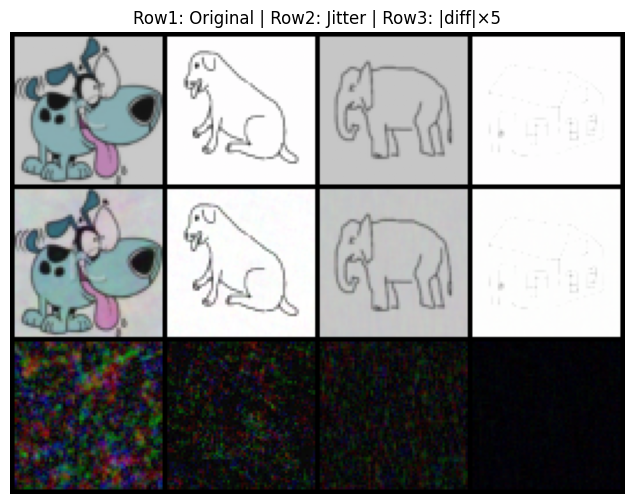

Epoch 1/10: 100%|██████████| 261/261 [01:09<00:00,  3.75it/s]


Epoch [1/10], Loss: 3.4554, Test Accuracy: 33.41%, Learning Rate: 0.000100


Epoch 2/10: 100%|██████████| 261/261 [01:09<00:00,  3.76it/s]


Epoch [2/10], Loss: 2.6166, Test Accuracy: 54.10%, Learning Rate: 0.000100


Epoch 3/10: 100%|██████████| 261/261 [01:09<00:00,  3.77it/s]


Epoch [3/10], Loss: 2.1220, Test Accuracy: 61.52%, Learning Rate: 0.000100


Epoch 4/10: 100%|██████████| 261/261 [01:09<00:00,  3.77it/s]


Epoch [4/10], Loss: 1.8429, Test Accuracy: 67.12%, Learning Rate: 0.000100


Epoch 5/10: 100%|██████████| 261/261 [01:09<00:00,  3.77it/s]


Epoch [5/10], Loss: 1.6255, Test Accuracy: 70.62%, Learning Rate: 0.000100


Epoch 6/10: 100%|██████████| 261/261 [01:09<00:00,  3.77it/s]


Epoch [6/10], Loss: 1.4798, Test Accuracy: 73.79%, Learning Rate: 0.000100


Epoch 7/10: 100%|██████████| 261/261 [01:09<00:00,  3.77it/s]


Epoch [7/10], Loss: 1.3521, Test Accuracy: 76.79%, Learning Rate: 0.000100


Epoch 8/10: 100%|██████████| 261/261 [01:09<00:00,  3.77it/s]


Epoch [8/10], Loss: 1.2242, Test Accuracy: 78.43%, Learning Rate: 0.000100


Epoch 9/10: 100%|██████████| 261/261 [01:09<00:00,  3.77it/s]


Epoch [9/10], Loss: 1.1323, Test Accuracy: 80.56%, Learning Rate: 0.000100


Epoch 10/10: 100%|██████████| 261/261 [01:09<00:00,  3.77it/s]


Epoch [10/10], Loss: 1.0584, Test Accuracy: 81.52%, Learning Rate: 0.000010
Finished Training
GT: dog      | Pred: horse    ❌
GT: dog      | Pred: person   ❌
GT: dog      | Pred: giraffe  ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: giraffe  ❌
GT: dog      | Pred: giraffe  ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: elephant ❌
GT: dog      | Pred: giraffe  ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: giraffe  ❌
GT: dog      | Pred: giraffe  ❌
GT: dog      | Pred: giraffe  ❌
GT: dog      | Pred: giraffe  ❌
GT: dog      | Pred: giraffe  ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: giraffe  ❌
GT: dog      | Pred: horse    ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: giraffe  ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: guitar   ❌
GT: dog   

Epoch 1/10:   0%|          | 0/261 [00:00<?, ?it/s]

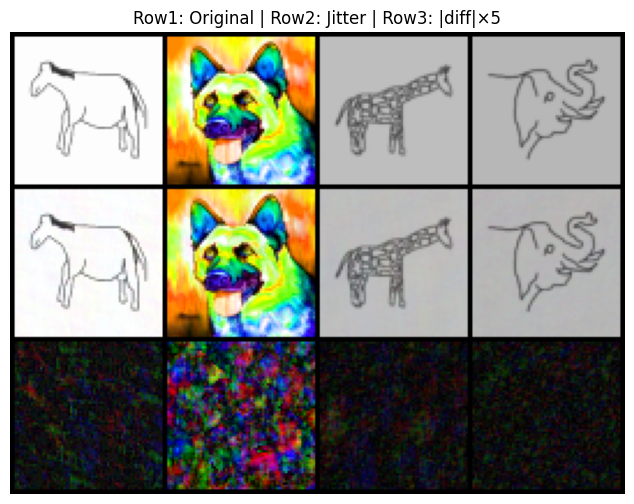

Epoch 1/10: 100%|██████████| 261/261 [01:09<00:00,  3.75it/s]


Epoch [1/10], Loss: 3.4665, Test Accuracy: 34.53%, Learning Rate: 0.000100


Epoch 2/10: 100%|██████████| 261/261 [01:09<00:00,  3.76it/s]


Epoch [2/10], Loss: 2.6008, Test Accuracy: 53.94%, Learning Rate: 0.000100


Epoch 3/10: 100%|██████████| 261/261 [01:09<00:00,  3.76it/s]


Epoch [3/10], Loss: 2.1350, Test Accuracy: 61.17%, Learning Rate: 0.000100


Epoch 4/10: 100%|██████████| 261/261 [01:09<00:00,  3.76it/s]


Epoch [4/10], Loss: 1.8412, Test Accuracy: 66.85%, Learning Rate: 0.000100


Epoch 5/10: 100%|██████████| 261/261 [01:09<00:00,  3.76it/s]


Epoch [5/10], Loss: 1.6353, Test Accuracy: 70.78%, Learning Rate: 0.000100


Epoch 6/10: 100%|██████████| 261/261 [01:09<00:00,  3.77it/s]


Epoch [6/10], Loss: 1.4706, Test Accuracy: 74.08%, Learning Rate: 0.000100


Epoch 7/10: 100%|██████████| 261/261 [01:09<00:00,  3.76it/s]


Epoch [7/10], Loss: 1.3196, Test Accuracy: 76.70%, Learning Rate: 0.000100


Epoch 8/10: 100%|██████████| 261/261 [01:09<00:00,  3.76it/s]


Epoch [8/10], Loss: 1.2507, Test Accuracy: 77.89%, Learning Rate: 0.000100


Epoch 9/10: 100%|██████████| 261/261 [01:09<00:00,  3.76it/s]


Epoch [9/10], Loss: 1.1403, Test Accuracy: 79.71%, Learning Rate: 0.000100


Epoch 10/10: 100%|██████████| 261/261 [01:09<00:00,  3.77it/s]


Epoch [10/10], Loss: 1.0635, Test Accuracy: 81.12%, Learning Rate: 0.000010
Finished Training
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: horse    ❌
GT: dog      | Pred: giraffe  ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: person   ❌
GT: dog      | Pred: person   ❌
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: person   ❌
GT: dog   

Epoch 1/10:   0%|          | 0/261 [00:00<?, ?it/s]

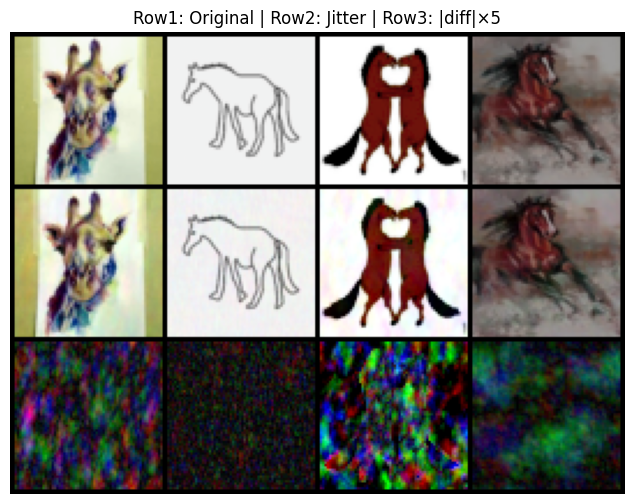

Epoch 1/10: 100%|██████████| 261/261 [01:09<00:00,  3.75it/s]


Epoch [1/10], Loss: 3.4470, Test Accuracy: 34.17%, Learning Rate: 0.000100


Epoch 2/10: 100%|██████████| 261/261 [01:09<00:00,  3.77it/s]


Epoch [2/10], Loss: 2.6022, Test Accuracy: 54.26%, Learning Rate: 0.000100


Epoch 3/10: 100%|██████████| 261/261 [01:09<00:00,  3.76it/s]


Epoch [3/10], Loss: 2.1330, Test Accuracy: 61.89%, Learning Rate: 0.000100


Epoch 4/10: 100%|██████████| 261/261 [01:09<00:00,  3.76it/s]


Epoch [4/10], Loss: 1.8825, Test Accuracy: 65.94%, Learning Rate: 0.000100


Epoch 5/10: 100%|██████████| 261/261 [01:09<00:00,  3.76it/s]


Epoch [5/10], Loss: 1.6365, Test Accuracy: 70.57%, Learning Rate: 0.000100


Epoch 6/10: 100%|██████████| 261/261 [01:09<00:00,  3.77it/s]


Epoch [6/10], Loss: 1.4883, Test Accuracy: 73.58%, Learning Rate: 0.000100


Epoch 7/10: 100%|██████████| 261/261 [01:09<00:00,  3.77it/s]


Epoch [7/10], Loss: 1.3400, Test Accuracy: 76.07%, Learning Rate: 0.000100


Epoch 8/10: 100%|██████████| 261/261 [01:09<00:00,  3.76it/s]


Epoch [8/10], Loss: 1.2409, Test Accuracy: 77.71%, Learning Rate: 0.000100


Epoch 9/10: 100%|██████████| 261/261 [01:09<00:00,  3.76it/s]


Epoch [9/10], Loss: 1.1504, Test Accuracy: 79.63%, Learning Rate: 0.000100


Epoch 10/10: 100%|██████████| 261/261 [01:09<00:00,  3.77it/s]


Epoch [10/10], Loss: 1.0695, Test Accuracy: 81.44%, Learning Rate: 0.000010
Finished Training
GT: dog      | Pred: elephant ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: giraffe  ❌
GT: dog      | Pred: giraffe  ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog   

Epoch 1/10: 100%|██████████| 261/261 [01:00<00:00,  4.35it/s]


Epoch 1/10 | Loss 3.4893 | TestAcc 47.84%


Epoch 2/10: 100%|██████████| 261/261 [00:59<00:00,  4.35it/s]


Epoch 2/10 | Loss 2.7502 | TestAcc 62.40%


Epoch 3/10: 100%|██████████| 261/261 [00:59<00:00,  4.35it/s]


Epoch 3/10 | Loss 2.3411 | TestAcc 62.87%


Epoch 4/10: 100%|██████████| 261/261 [00:59<00:00,  4.35it/s]


Epoch 4/10 | Loss 2.0848 | TestAcc 68.08%


Epoch 5/10: 100%|██████████| 261/261 [00:59<00:00,  4.35it/s]


Epoch 5/10 | Loss 1.8494 | TestAcc 72.51%


Epoch 6/10: 100%|██████████| 261/261 [00:59<00:00,  4.35it/s]


Epoch 6/10 | Loss 1.8991 | TestAcc 68.50%


Epoch 7/10: 100%|██████████| 261/261 [00:59<00:00,  4.35it/s]


Epoch 7/10 | Loss 1.7214 | TestAcc 68.14%


Epoch 8/10: 100%|██████████| 261/261 [00:59<00:00,  4.35it/s]


Epoch 8/10 | Loss 1.5620 | TestAcc 73.83%


Epoch 9/10: 100%|██████████| 261/261 [00:59<00:00,  4.35it/s]


Epoch 9/10 | Loss 1.5141 | TestAcc 65.93%


Epoch 10/10: 100%|██████████| 261/261 [00:59<00:00,  4.35it/s]


Epoch 10/10 | Loss 1.4081 | TestAcc 78.44%
Finished Training
GT: dog      | Pred: horse    ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: giraffe  ❌
GT: dog      | Pred: guitar   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: giraffe  ❌
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog    

Epoch 1/10: 100%|██████████| 261/261 [00:59<00:00,  4.35it/s]


Epoch 1/10 | Loss 3.5476 | TestAcc 45.33%


Epoch 2/10: 100%|██████████| 261/261 [00:59<00:00,  4.35it/s]


Epoch 2/10 | Loss 2.7963 | TestAcc 59.34%


Epoch 3/10: 100%|██████████| 261/261 [00:59<00:00,  4.35it/s]


Epoch 3/10 | Loss 2.3582 | TestAcc 60.42%


Epoch 4/10: 100%|██████████| 261/261 [00:59<00:00,  4.35it/s]


Epoch 4/10 | Loss 2.1044 | TestAcc 67.84%


Epoch 5/10: 100%|██████████| 261/261 [00:59<00:00,  4.35it/s]


Epoch 5/10 | Loss 1.9235 | TestAcc 69.22%


Epoch 6/10: 100%|██████████| 261/261 [00:59<00:00,  4.35it/s]


Epoch 6/10 | Loss 1.7745 | TestAcc 69.46%


Epoch 7/10: 100%|██████████| 261/261 [00:59<00:00,  4.35it/s]


Epoch 7/10 | Loss 1.6178 | TestAcc 66.77%


Epoch 8/10: 100%|██████████| 261/261 [00:59<00:00,  4.35it/s]


Epoch 8/10 | Loss 1.5719 | TestAcc 61.44%


Epoch 9/10: 100%|██████████| 261/261 [00:59<00:00,  4.36it/s]


Epoch 9/10 | Loss 1.4841 | TestAcc 68.92%


Epoch 10/10: 100%|██████████| 261/261 [00:59<00:00,  4.35it/s]


Epoch 10/10 | Loss 1.4192 | TestAcc 70.72%
Finished Training
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: elephant ❌
GT: dog      | Pred: guitar   ❌
GT: dog      | Pred: guitar   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: horse    ❌
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: elephant ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog    

Epoch 1/10: 100%|██████████| 261/261 [00:59<00:00,  4.35it/s]


Epoch 1/10 | Loss 3.5179 | TestAcc 46.23%


Epoch 2/10: 100%|██████████| 261/261 [00:59<00:00,  4.35it/s]


Epoch 2/10 | Loss 2.8389 | TestAcc 60.24%


Epoch 3/10: 100%|██████████| 261/261 [00:59<00:00,  4.35it/s]


Epoch 3/10 | Loss 2.3611 | TestAcc 64.19%


Epoch 4/10: 100%|██████████| 261/261 [00:59<00:00,  4.35it/s]


Epoch 4/10 | Loss 2.1101 | TestAcc 66.71%


Epoch 5/10: 100%|██████████| 261/261 [00:59<00:00,  4.36it/s]


Epoch 5/10 | Loss 1.9161 | TestAcc 71.62%


Epoch 6/10: 100%|██████████| 261/261 [00:59<00:00,  4.35it/s]


Epoch 6/10 | Loss 1.7751 | TestAcc 73.23%


Epoch 7/10: 100%|██████████| 261/261 [00:59<00:00,  4.35it/s]


Epoch 7/10 | Loss 1.7175 | TestAcc 77.66%


Epoch 8/10: 100%|██████████| 261/261 [00:59<00:00,  4.35it/s]


Epoch 8/10 | Loss 1.5716 | TestAcc 75.27%


Epoch 9/10: 100%|██████████| 261/261 [00:59<00:00,  4.35it/s]


Epoch 9/10 | Loss 1.4369 | TestAcc 79.16%


Epoch 10/10: 100%|██████████| 261/261 [00:59<00:00,  4.36it/s]


Epoch 10/10 | Loss 1.4085 | TestAcc 76.05%
Finished Training
GT: dog      | Pred: horse    ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: horse    ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: elephant ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: giraffe  ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: horse    ❌
GT: dog      | Pred: horse    ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog    

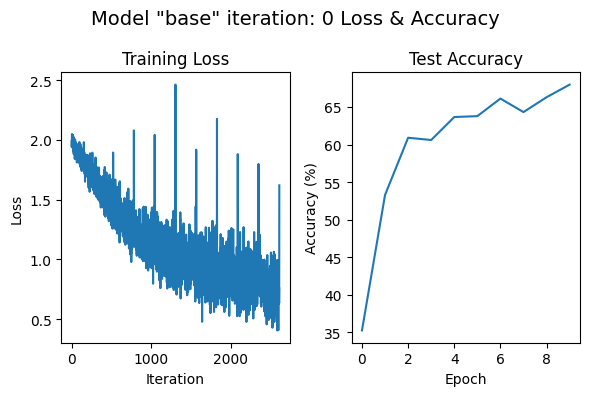

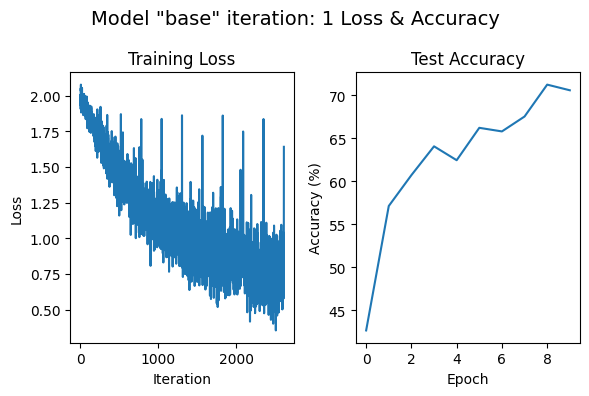

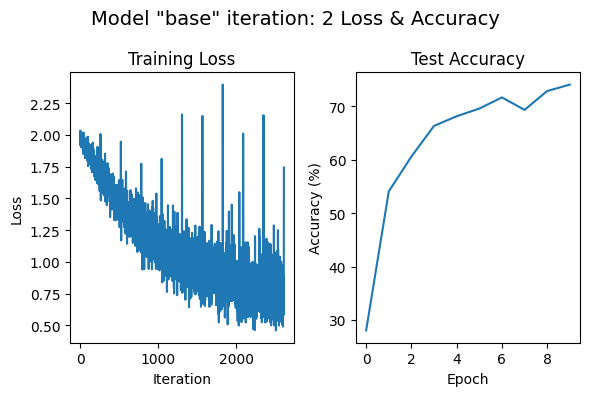

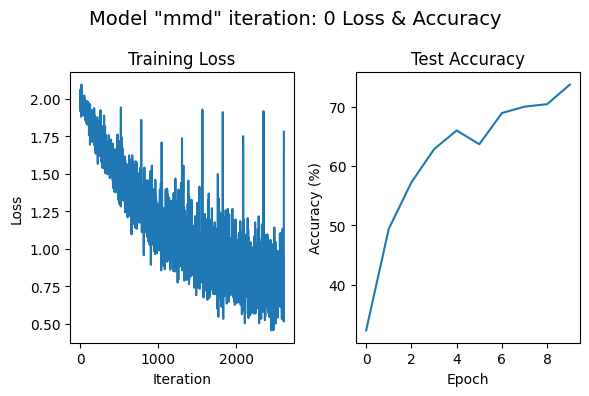

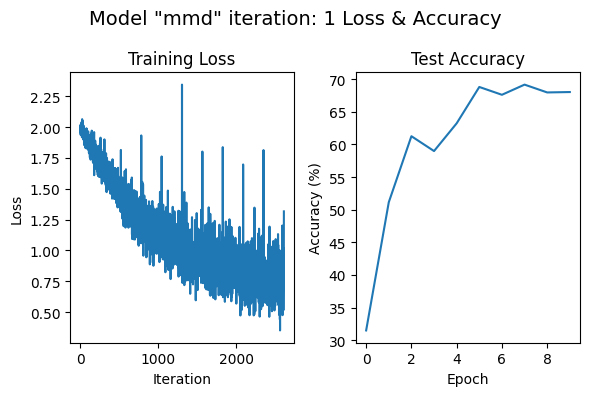

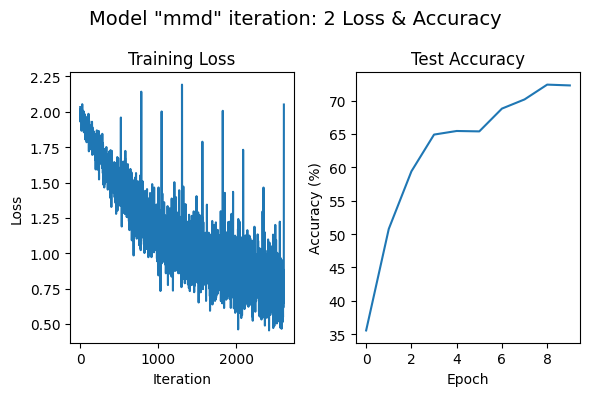

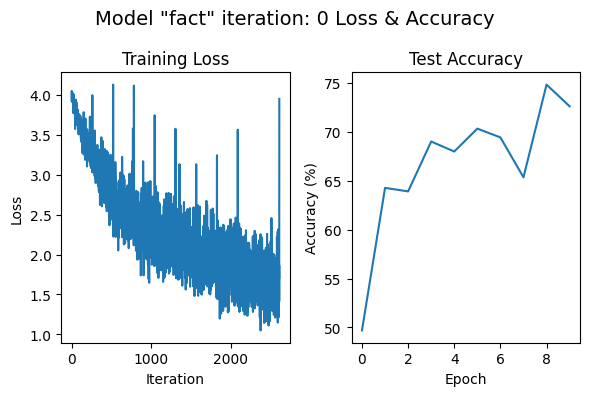

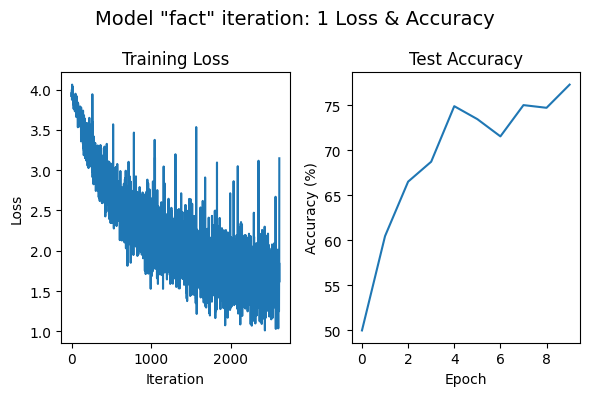

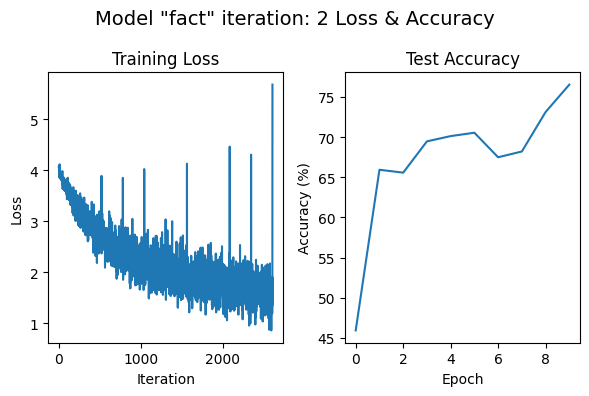

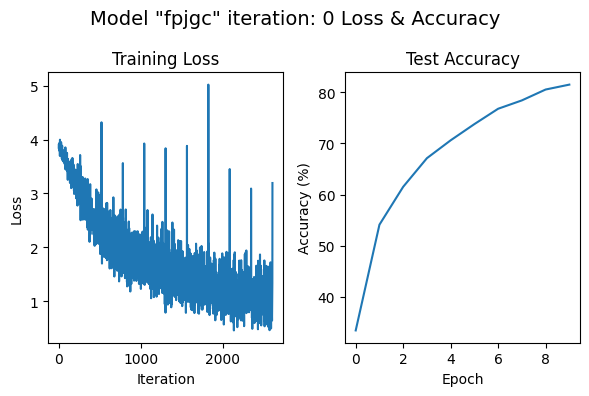

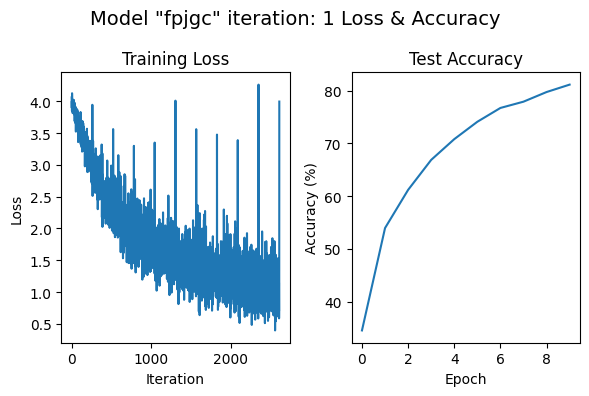

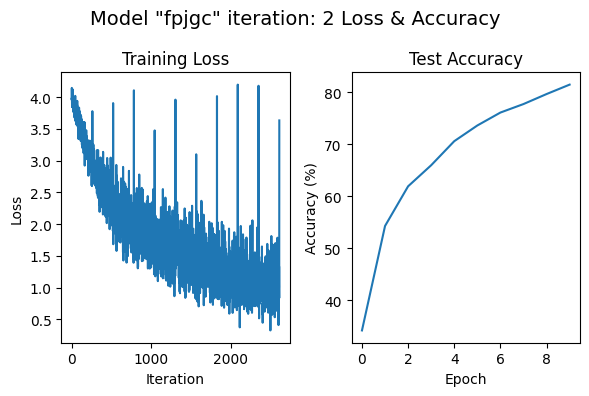

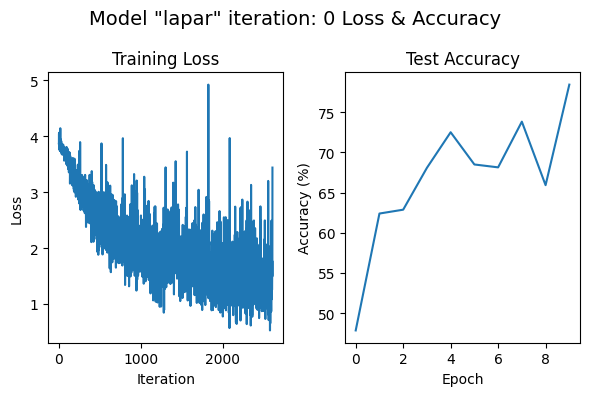

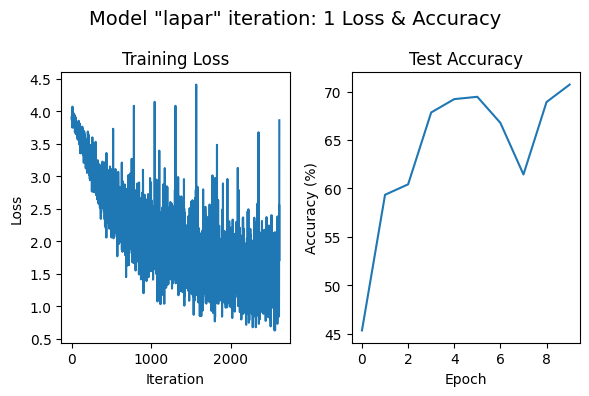

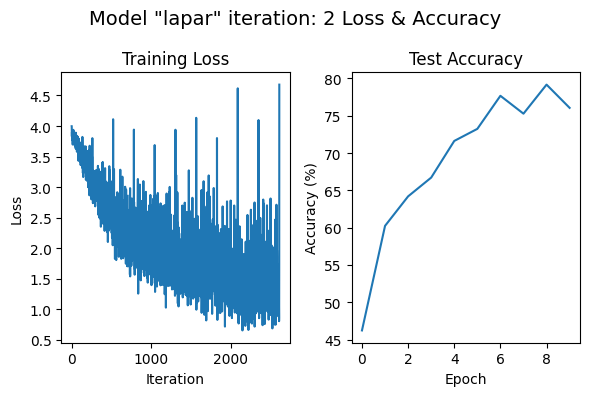

In [ ]:
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_functions = [
    ('base', train_base),
    ('mmd', train_mmd),
    ('fact', train_fact),
    ('fpjgc', train_fpjgc),
    ('lapar', train_lapar),
]

iteration = 5

train_result = []
test_result = []

for name, func in train_functions:
    for run in range(iteration):
        # Training
        print(f"Running: train_{name}()")
        start_time = time.time()
        acc, train_losses, test_accuracies  = func()
        end_time = time.time()
        duration = end_time - start_time
        train_result.append((name, run, acc, duration, train_losses, test_accuracies))

        #Evaluate Curated PACS
        model_path = f'./{model_name}_{name}'
        if 'mmd' in model_path:
            model = ResNetWithFeatures(num_classes=7)
        else:
            model = models.resnet50(weights='ResNet50_Weights.DEFAULT')  # ✅ pretrained=True와 동일
            num_features = model.fc.in_features
            model.fc = torch.nn.Linear(num_features, 7)  # ✅ PACS용 7개 클래스 출력

        state_dict = torch.load(model_path)   # ✅ weights_only 제거
        model.load_state_dict(state_dict)
        model.eval()
        model.to(device)

        acc_test = evaluate_curated_pacs(model)
        test_result.append((name, run, acc_test*100))

# Print Resoults
print("\n=== Train Accuracy Results ===")
for name, run, acc, duration, train_losses, test_accuracies in train_result:
    print(f"{name}[{run}] → {acc:.2f}% (took {duration:.2f}s)")

print("\n=== Test Accuracy Results ===")
for name, run, acc in test_result:
    print(f"{name}[{run}] → {acc:.2f}%")

for name, run, acc, duration, train_losses, test_accuracies in train_result:
    # Plotting after training is finished
    plt.figure(figsize=(6, 4))

    plt.suptitle(f"Model \"{name}\" iteration: {run} Loss & Accuracy",
                 fontsize=14)  

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    # Plot test accuracy
    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies)
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')

    plt.tight_layout()
    plt.show()

# Evaluate Curated PACS

In [ ]:
def evaluate_curated_pacs(model):
    # Custom Dataset
    class CustomDataset(Dataset):
        def __init__(self, root_dir, transform=None):
            self.root_dir = root_dir
            self.transform = transform
            self.images = []
            self.labels = []
            self.class_to_idx = {'dog': 0, 'elephant': 1, 'giraffe': 2, 'guitar': 3, 'horse': 4, 'house': 5, 'person': 6}
            self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
            
            for cls_name in self.class_to_idx.keys():
                cls_dir = os.path.join(self.root_dir, cls_name)
                for img_name in os.listdir(cls_dir):
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.images.append(os.path.join(cls_dir, img_name))
                        self.labels.append(self.class_to_idx[cls_name])

        def __len__(self):
            return len(self.images)

        def __getitem__(self, idx):
            img_path = self.images[idx]
            label = self.labels[idx]
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label

    # Load test data
    root_dir_test = './CuratedPACS'
    dataset_test = CustomDataset(root_dir_test, transform=transform_test)
    loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

    # Evaluation
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader_test:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            # 라벨 문자열 출력
            for t, p in zip(labels.cpu(), predicted.cpu()):
                true_name = dataset_test.idx_to_class[t.item()]
                pred_name = dataset_test.idx_to_class[p.item()]
                print(f"GT: {true_name:8s} | Pred: {pred_name:8s} {'✅' if t==p else '❌'}")

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    print(f"\nTest Accuracy: {100 * correct / total:.2f}%")
    return (correct / total)

In [ ]:
# Load model
model_list = ['base', 'mmd', 'fact', 'fpjgc', 'lapar']
model_paths = [f'./{model_name}_{variant}' for variant in model_list]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_accuracies = []

for model_path in model_paths:
    if 'mmd' in model_path:
        model = ResNetWithFeatures(num_classes=7)
    else:
        model = models.resnet50(weights='ResNet50_Weights.DEFAULT')  # ✅ pretrained=True와 동일
        num_features = model.fc.in_features
        model.fc = torch.nn.Linear(num_features, 7)  # ✅ PACS용 7개 클래스 출력

    state_dict = torch.load(model_path)   # ✅ weights_only 제거
    model.load_state_dict(state_dict)
    model.eval()
    model.to(device)

    acc = evaluate_curated_pacs(model)
    test_accuracies.append((model_path, acc))

print("\n=== Test Accuracy Results ===")
for path, acc in test_accuracies:
    print(f"{path}: {acc:.2f}%")

/tmp/ipykernel_34001/2477631611.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)   # ✅ weights_only 제거


GT: dog      | Pred: giraffe  ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: person   ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: giraffe  ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: elephant ❌
GT: dog      | Pred: person   ❌
GT: dog      | Pred: giraffe  ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: horse    ❌
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog      | Pred: dog      ✅
GT: dog 

# TA Test

In [ ]:
# Test code - DO NOT RUN, and DO NOT MODIFY.
# TAs will evaluate your model using their curated dataset.
if TEST_MODE:
	del model
	model = models.resnet50()
	model.load_state_dict(torch.load(f'./{model_name}'))
	
	root_dir_test = '/work/datasets/CuratedPACS'

	class CustomDataset(Dataset):
		def __init__(self, root_dir, transform=None):
			self.root_dir = root_dir
			self.transform = transform
			self.images = []
			self.labels = []
			self.class_to_idx = {'dog': 0, 'elephant': 1, 'giraffe': 2, 'guitar': 3, 'horse': 4, 'house': 5, 'person': 6}
			self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
			for cls_name in self.class_to_idx.keys:
				cls_dir = os.path.join(self.root_dir, cls_name)
				for img_name in os.listdir(cls_dir):
					self.images.append(os.path.join(cls_dir, img_name))
					self.labels.append(self.class_to_idx[cls_name])
			
		def __len__(self):
			return len(self.images)

	dataset_test = CustomDataset(root_dir, transform=transform_test)

	# Peform test with the test dataset
	correct = 0
	total = 0
	with torch.no_grad():
		for inputs, labels in loader_test:
			inputs, labels = inputs.to(device), labels.to(device)
			outputs = model(inputs)
			_, predicted = outputs.max(1)
			total += labels.size(0)
			correct += predicted.eq(labels).sum().item()

	print(f'Test Accuracy: {100 * correct / total:.2f}%')